    classifiers used

        regression
            linear regression >> with polyfeatures
            logistic regression
            lasso regression
            ridge regression

        knn
        desicion tree
        svm
        naivebias

        ensemble methods:
            bagging
                random forest 

            boosting
                gradient boost  
                ada boost
                xg boost
                cat boost


        hyperparameter tuning(depending on model):
            grid search


        evaluation and validation :
            cross validation
            ROC-AUC curve
            r2 score
            confuction matrix

## imports

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from IPython.display import display


In [29]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report , r2_score
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import normalize
from sklearn.svm import SVC


import seaborn as sns
import hvplot.pandas

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)


## helper functions for plotting and visualization


In [30]:
# helper functions for plotting and visualization

#  for plotting confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))
    # cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    score = model.score(x_test, y_test)
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5,
                square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size=15)


# for printing the precision , recall , f1-score , ROC(AOC) , classification report
def print_metrics(model, x_train, x_test, y_train, y_test):
    print("The Training Accuracy is: ", model.score(x_train, y_train))
    print("The Testing Accuracy is: ", model.score(x_test, y_test))
    y_pred = model.predict(x_test)
    r2__score = r2_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    score = f1_score(y_test, y_pred, average='binary')
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    print("The R2 score is: ", r2__score)
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('F1-Measure: %.3f' % score)
    print('ROC_AUC: %.3f' % ROC_AUC)
    print(
        f'the classification report is \n {classification_report(y_test, y_pred)}')


# for plotting the ROC curve (takes the model and test data as inputs)
def plot_roc(model, name,  x_test, y_test):
    pred_prob = model.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])

    # roc curve for tpr = fpr
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(10, 10))
    plt.style.use('seaborn')

    plt.plot(fpr, tpr, linestyle='--', color='green',
             label=f'{name} ROC (AUC = %0.4f)' % auc_score)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.legend(loc='lower right')
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()


## data preprocessing and EDA

    >>> 

In [4]:
import glob
path = glob.glob(r'./IBM/*.csv')
path

['./IBM\\WA_Fn-UseC_-HR-Employee-Attrition.csv']

In [5]:
df = pd.read_csv(path[0])

In [6]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [7]:
# print(df.info())
# display(df.describe())

In [8]:
print('size of the original dataframe is: ', df.shape)

size of the original dataframe is:  (1470, 35)


In [9]:
print('max perf' , df['PerformanceRating'].max())
print('min perf',df['PerformanceRating'].min())
# print(df['PerformanceRating'].head())
for column in df[['Attrition', 'PerformanceRating']].columns:
    print(f"{column}: Number of unique values {df[column].nunique()}")
    print("==========================================================")


max perf 4
min perf 3
Attrition: Number of unique values 2
PerformanceRating: Number of unique values 2


In [10]:
df['Attrition'].replace(['Yes', 'No'], [1, 0], inplace=True)
print(df['Attrition'].head().to_markdown())


|    |   Attrition |
|---:|------------:|
|  0 |           1 |
|  1 |           0 |
|  2 |           1 |
|  3 |           0 |
|  4 |           0 |


In [11]:
from sklearn.preprocessing import LabelEncoder
categorical_col = []
for column in df.columns:
    if df[column].dtype == object and df[column].nunique() < 10:
        categorical_col.append(column)

# df['Attrition'] = df.Attrition.astype("category").cat.codes

label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

# now the dataset is all numerical

In [62]:
x = np.array(df.drop(['Attrition', 'PerformanceRating'], axis=1))
y = np.array(df['Attrition'])
# y_performance = np.array(df['PerformanceRating'])
# print(df.shape)
print(x.shape)
print(y.shape)
# print(y_attrition.shape)
# print(y_performance.shape)
# y[:,0]1
y

(1470, 33)
(1470,)


array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
# x_train_attr, x_test_attr, y_train_attr, y_test_attr = train_test_split(
#     x, y_attrition, test_size=0.2, random_state=42)
# x_train_perf, x_test_perf, y_train_perf, y_test_perf = train_test_split(
#     x, y_performance, test_size=0.2, random_state=42)
# print(len(x_train_attr) ,len(x_test_attr) ,len(y_train_attr) ,len(y_test_attr))


## various models training , tuning and Evaluation 
        each model has 2 copies trained and tuned >> (for both attrition and for performance)
        first we run all the models on attrition then run the same code for performance later

### KNN

In [53]:
k_values = [i for i in range(1, 60)]
k_acc_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    cv_scores = cross_val_score(knn, x, y, cv=10)
    k_acc_scores.append(cv_scores.mean())



In [64]:
max_index = k_acc_scores. index(max(k_acc_scores))
print(max_index+1, k_acc_scores[max_index])


10 0.8401360544217689


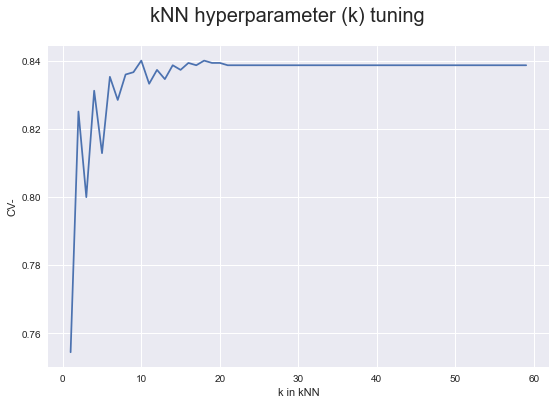

In [65]:
fig2 = plt.figure()
plt.plot(k_values, k_acc_scores)
plt.xlabel('k in kNN')
plt.ylabel('CV-')
fig2.suptitle('kNN hyperparameter (k) tuning ', fontsize=20)
plt.show()



In [68]:
model_knn = KNeighborsClassifier(n_neighbors=max_index+1, n_jobs=-1)
model_knn.fit(x_train,y_train)


KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

The Training Accuracy is:  0.8375850340136054
The Testing Accuracy is:  0.8537414965986394
The R2 score is:  -0.27119155354449487
Precision: 0.000
Recall: 0.000
F1-Measure: 0.000
ROC_AUC: 0.568
the classification report is 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       255
           1       0.00      0.00      0.00        39

    accuracy                           0.85       294
   macro avg       0.43      0.49      0.46       294
weighted avg       0.75      0.85      0.80       294



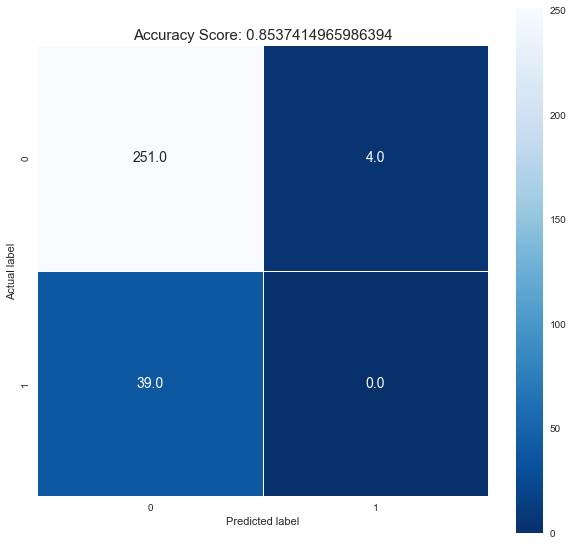

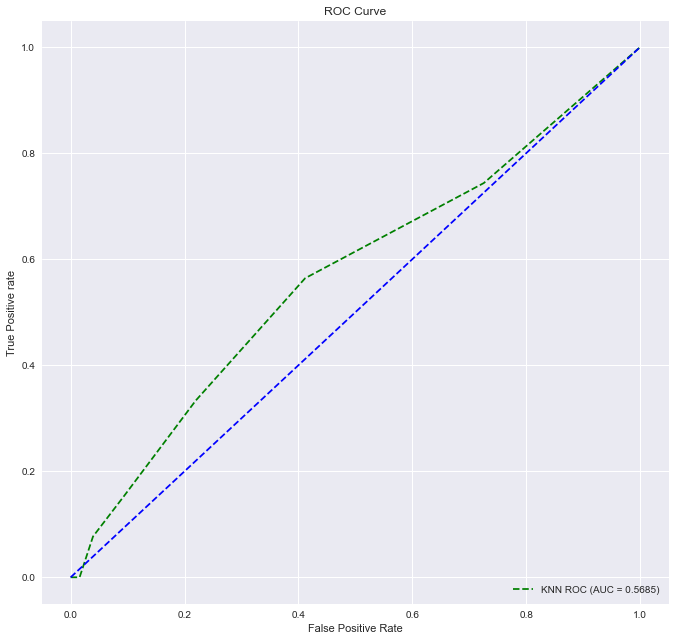

In [69]:
print_metrics(model_knn, x_train, x_test, y_train, y_test)
plot_confusion_matrix(model_knn, x_test, y_test)
plot_roc(model_knn, 'KNN', x_test, y_test)


### Naive bayes

In [58]:
model_NB = GaussianNB()
model_NB.fit(x_train,y_train)
pre=model_NB.predict(x_test)

The Training Accuracy is:  0.8027210884353742
The Testing Accuracy is:  0.8435374149659864
The R2 score is:  -0.35987933634992464
Precision: 0.429
Recall: 0.538
F1-Measure: 0.477
ROC_AUC: 0.749
the classification report is 
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       255
           1       0.43      0.54      0.48        39

    accuracy                           0.84       294
   macro avg       0.68      0.71      0.69       294
weighted avg       0.86      0.84      0.85       294



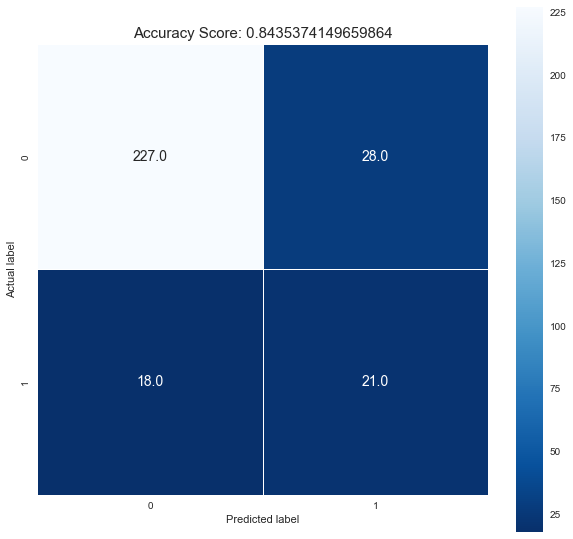

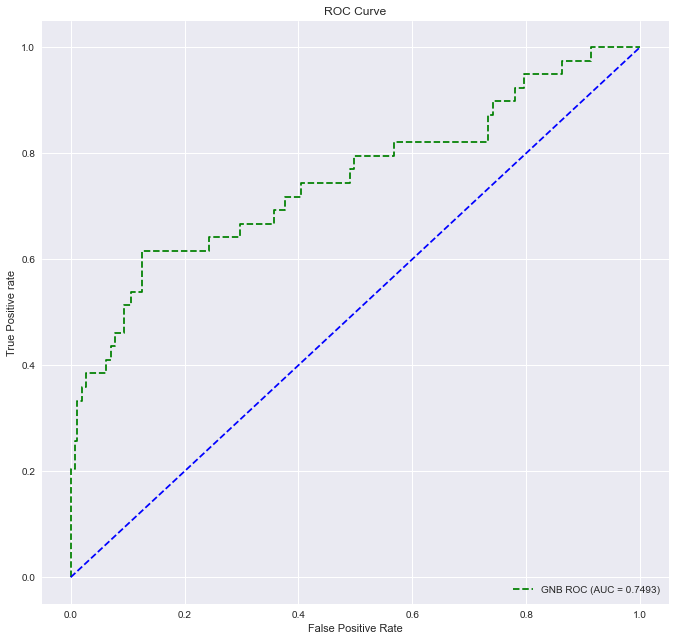

In [59]:
print_metrics(model_NB , x_train , x_test , y_train , y_test)
plot_confusion_matrix(model_NB , x_test , y_test)
plot_roc(model_NB , 'GNB' , x_test , y_test)

### Logistic Regression


In [81]:
model = LogisticRegression(max_iter=1000000)
model.fit(x_train,y_train)
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [74]:
print_metrics(model, x_train, x_test, y_train, y_test)


The Training Accuracy is:  0.8656462585034014
The Testing Accuracy is:  0.9047619047619048
The R2 score is:  0.17224736048265454
Precision: 0.789
Recall: 0.385
F1-Measure: 0.517
ROC_AUC: 0.767
the classification report is 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       255
           1       0.79      0.38      0.52        39

    accuracy                           0.90       294
   macro avg       0.85      0.68      0.73       294
weighted avg       0.90      0.90      0.89       294



In [85]:
param_grid = [
    {
        'penalty': ['l2', 'l1', 'elasticnet', 'none'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        # 'C'  : np.logspace(-4, 4, 20),
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
best_model_search = GridSearchCV(LogisticRegression(
    max_iter=1000000), param_grid=param_grid, n_jobs=-1, cv=cv, verbose=True, scoring='accuracy', error_score=0)
grid_result = best_model_search.fit(x_train, y_train)
model_log_reg = grid_result.best_estimator_


Fitting 30 folds for each of 60 candidates, totalling 1800 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

In [86]:
model_log_reg.get_params()


{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

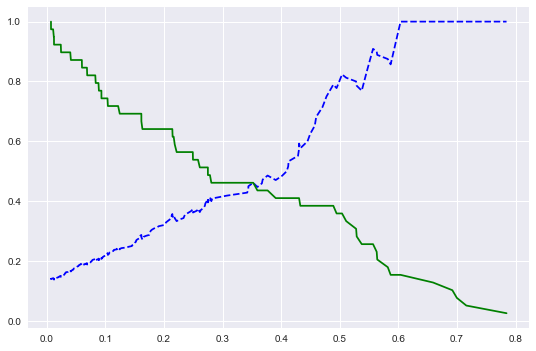

In [87]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(
    y_test, model_log_reg.predict_proba(x_test)[:, 1])
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')


The Training Accuracy is:  0.8681972789115646
The Testing Accuracy is:  0.9047619047619048
The R2 score is:  0.17224736048265454
Precision: 0.824
Recall: 0.359
F1-Measure: 0.500
ROC_AUC: 0.764
the classification report is 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       255
           1       0.82      0.36      0.50        39

    accuracy                           0.90       294
   macro avg       0.87      0.67      0.72       294
weighted avg       0.90      0.90      0.89       294



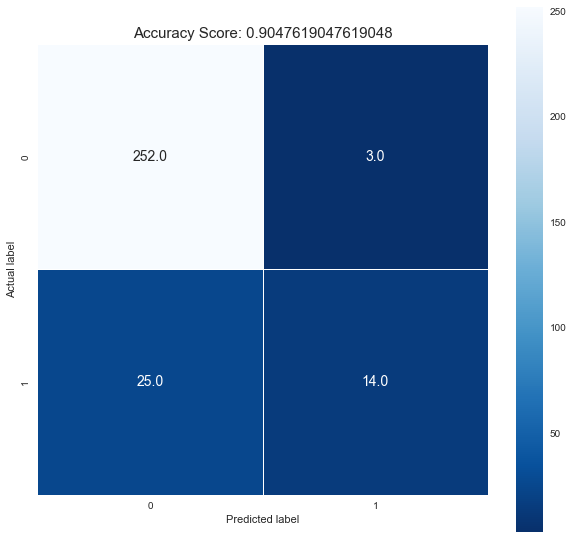

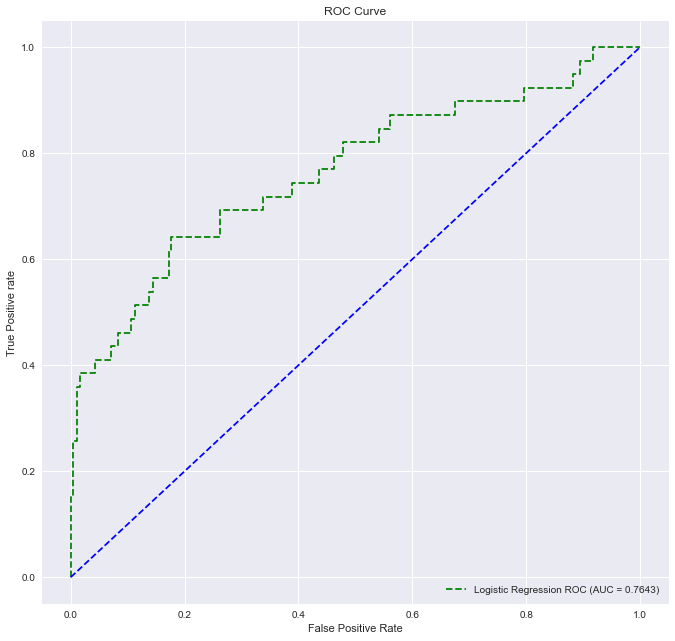

In [89]:
print_metrics(model_log_reg, x_train, x_test, y_train, y_test)
plot_confusion_matrix(model_log_reg, x_test, y_test)
plot_roc(model_log_reg, 'Logistic Regression', x_test, y_test)


### Decision tree

In [90]:
space =dict()
space['max_depth']=[i for i in range(1,50)]
space['max_leaf_nodes']=[i for i in range(2,50)]
space['min_samples_split']=[i for i in range(2,10)]
space['min_samples_leaf']=[i for i in range(1,4)]
# space['criterion']=['gini','entropy']
space['criterion']=['gini' ]

In [91]:
des_tree = tree.DecisionTreeClassifier(splitter='best',random_state=42)   
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)        
random_search = RandomizedSearchCV(des_tree, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=42,error_score='raise' , verbose  = 1)    
search_result = random_search.fit(x_train, y_train)
model_tree = search_result.best_estimator_

Fitting 30 folds for each of 500 candidates, totalling 15000 fits


In [92]:
print('Best Score: %s' % search_result.best_score_)
print('Best Hyperparameters: %s' % search_result.best_params_)
print(model_tree)


Best Score: 0.8480588150079676
Best Hyperparameters: {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_leaf_nodes': 11, 'max_depth': 29, 'criterion': 'gini'}
DecisionTreeClassifier(max_depth=29, max_leaf_nodes=11, min_samples_leaf=2,
                       min_samples_split=4, random_state=42)


The Training Accuracy is:  0.8792517006802721
The Testing Accuracy is:  0.8605442176870748
The R2 score is:  -0.2120663650075416
Precision: 0.375
Recall: 0.077
F1-Measure: 0.128
ROC_AUC: 0.529
the classification report is 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       255
           1       0.38      0.08      0.13        39

    accuracy                           0.86       294
   macro avg       0.62      0.53      0.53       294
weighted avg       0.81      0.86      0.82       294



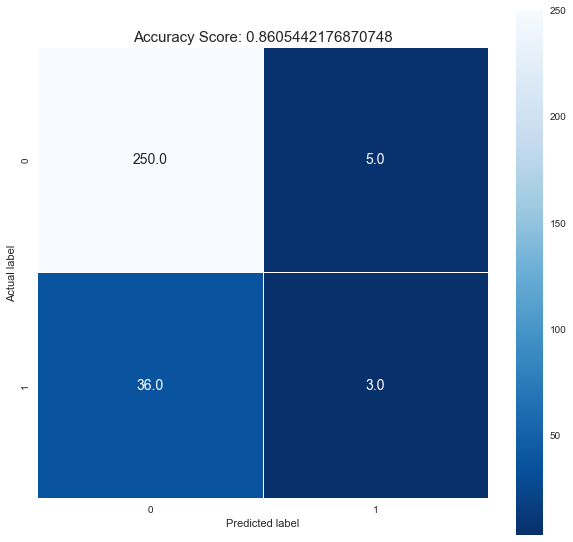

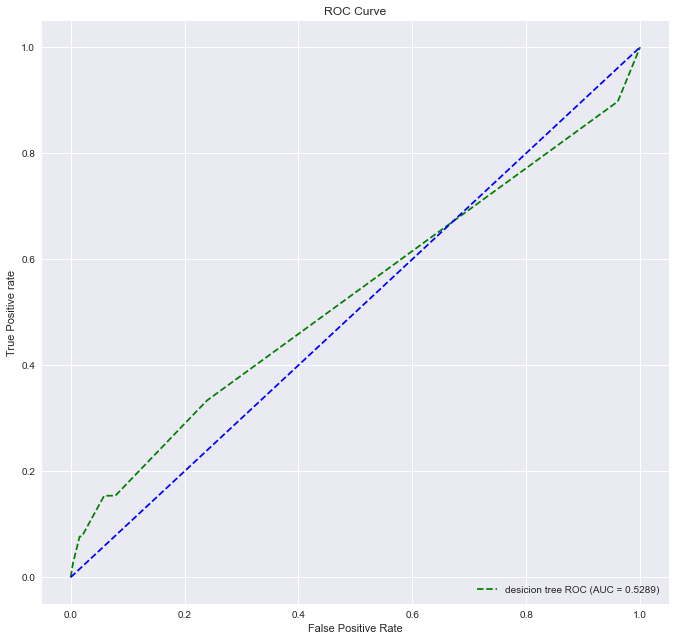

In [93]:
print_metrics(model_tree,x_train,x_test,y_train,y_test)
plot_confusion_matrix(model_tree , x_test , y_test)
plot_roc(model_tree , 'desicion tree',x_test,y_test)

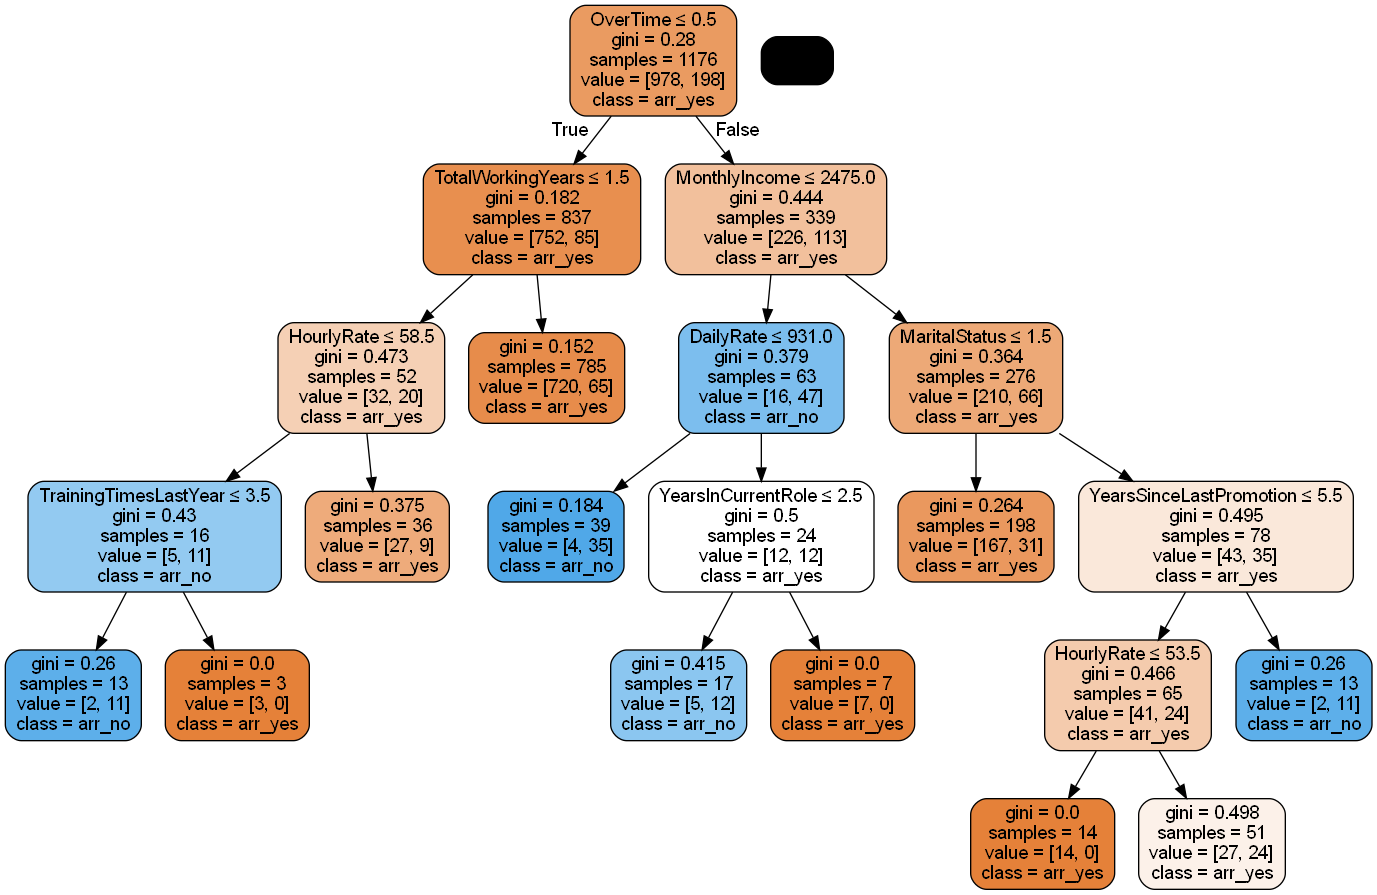

In [97]:
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data, rounded=True, filled=True, special_characters=True,
                feature_names=df.drop(['Attrition', 'PerformanceRating'], axis=1).columns, class_names=['arr_yes', 'arr_no'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('desicion_tree.png')
Image(graph.create_png())
